In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.optim.lr_scheduler import SequentialLR, LinearLR, MultiStepLR

In [2]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 128


train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.482, 0.4465], std=[0.247, 0.2435, 0.2616]),
])

test_transform = transforms.ToTensor()

#Downloads datasets
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
train_size = 45000
val_size = 5000
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_dataset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=test_transform),
    val_dataset.indices
)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [3]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        out = F.relu(x)
        return out


In [4]:
#Defines Convolutional Neural Network

class Resnet(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.reslayers = nn.ModuleList()

        #Sets size of network. Paper uses n = {3,5,7,9}, but starting with smallest at 3
        n = 3

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=True))

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=True))

        for _ in range(n):
            self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))

        self.pool2 = nn.AvgPool2d(kernel_size=8,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        for reslayer in self.reslayers:
            x = reslayer(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = self.out(x)
        
        return out

In [5]:
def he_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [6]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate numpy arrays to save our training data and plot it
    save_every = 50
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        if (batch_index+1) % save_every == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0


    return batches, losses, accuracy

    

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()


    avg_loss_across_batches = running_loss / len(valloader)
    avg_accuracy_across_batches = (running_accuracy / len(valloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

In [7]:
def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Train Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Train Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Val Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Val Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Batch Number')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

Epoch 1
Batch50, Loss: 2.317, Accuracy: 12.9%
Batch100, Loss: 2.221, Accuracy: 15.8%
Batch150, Loss: 2.136, Accuracy: 18.4%
Batch200, Loss: 2.062, Accuracy: 20.2%
Batch250, Loss: 2.033, Accuracy: 21.9%
Batch300, Loss: 2.004, Accuracy: 22.7%
Batch350, Loss: 1.989, Accuracy: 23.4%
Val Loss: 2.586, Val Accuracy: 10.6%
*****************************************



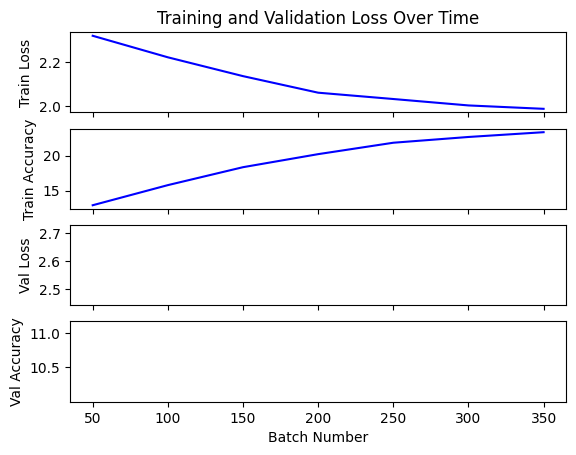

Epoch 2
Batch50, Loss: 1.917, Accuracy: 26.8%
Batch100, Loss: 1.736, Accuracy: 34.1%
Batch150, Loss: 1.700, Accuracy: 35.7%
Batch200, Loss: 1.592, Accuracy: 40.4%
Batch250, Loss: 1.536, Accuracy: 42.7%
Batch300, Loss: 1.526, Accuracy: 43.7%
Batch350, Loss: 1.432, Accuracy: 47.3%
Val Loss: 3.343, Val Accuracy: 13.3%
*****************************************



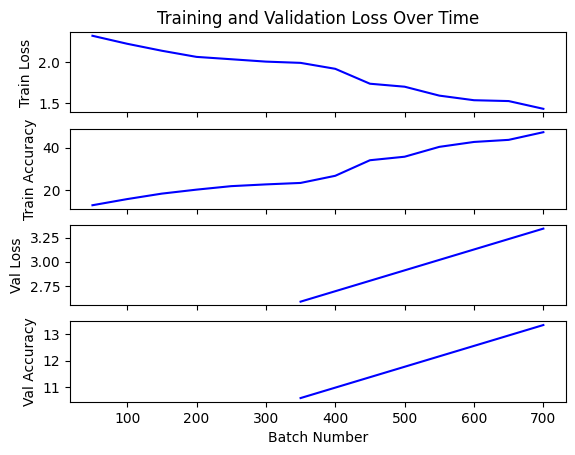

Epoch 3
Batch50, Loss: 1.499, Accuracy: 44.5%
Batch100, Loss: 1.412, Accuracy: 48.2%
Batch150, Loss: 1.317, Accuracy: 52.3%
Batch200, Loss: 1.271, Accuracy: 53.5%
Batch250, Loss: 1.251, Accuracy: 55.2%
Batch300, Loss: 1.183, Accuracy: 57.6%
Batch350, Loss: 1.163, Accuracy: 58.0%
Val Loss: 2.966, Val Accuracy: 16.6%
*****************************************



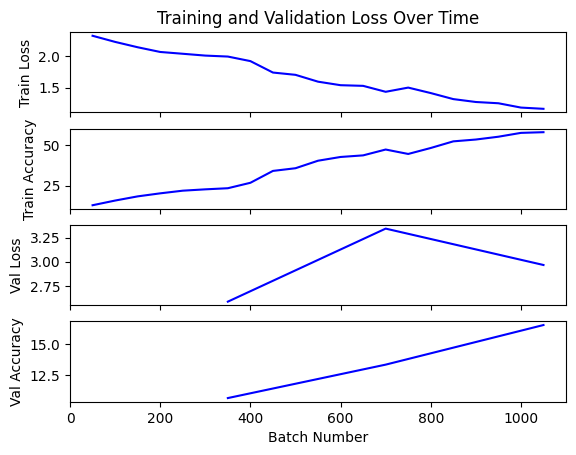

Epoch 4
Batch50, Loss: 1.194, Accuracy: 57.2%
Batch100, Loss: 1.138, Accuracy: 59.4%
Batch150, Loss: 1.146, Accuracy: 58.5%
Batch200, Loss: 1.067, Accuracy: 62.3%
Batch250, Loss: 1.089, Accuracy: 61.5%
Batch300, Loss: 1.043, Accuracy: 62.5%
Batch350, Loss: 1.032, Accuracy: 63.1%
Val Loss: 2.352, Val Accuracy: 27.9%
*****************************************



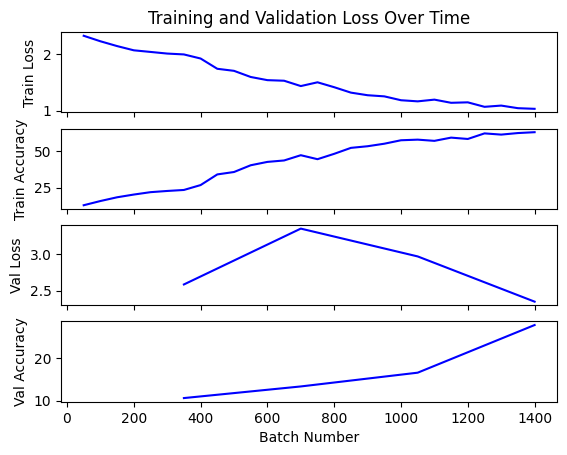

Epoch 5
Batch50, Loss: 1.040, Accuracy: 63.1%
Batch100, Loss: 1.037, Accuracy: 62.7%
Batch150, Loss: 0.991, Accuracy: 64.5%
Batch200, Loss: 0.974, Accuracy: 65.4%
Batch250, Loss: 0.961, Accuracy: 65.7%
Batch300, Loss: 0.934, Accuracy: 66.9%
Batch350, Loss: 0.908, Accuracy: 67.6%
Val Loss: 3.257, Val Accuracy: 15.5%
*****************************************



c:\Users\hagan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


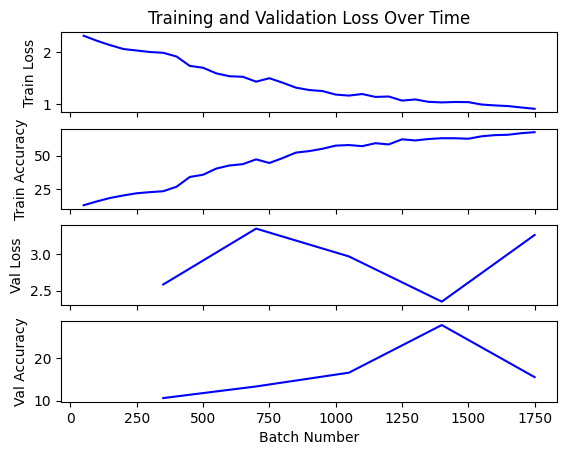

Epoch 6
Batch50, Loss: 0.916, Accuracy: 67.6%
Batch100, Loss: 0.911, Accuracy: 68.3%
Batch150, Loss: 0.887, Accuracy: 69.0%
Batch200, Loss: 0.888, Accuracy: 69.5%
Batch250, Loss: 0.881, Accuracy: 69.2%
Batch300, Loss: 0.846, Accuracy: 70.2%
Batch350, Loss: 0.848, Accuracy: 70.8%
Val Loss: 3.337, Val Accuracy: 19.2%
*****************************************



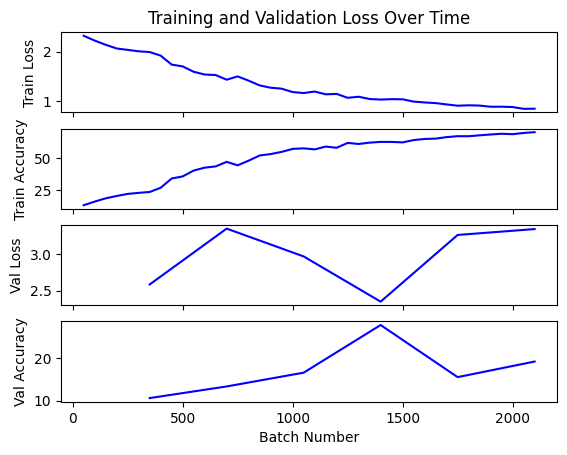

Epoch 7
Batch50, Loss: 0.797, Accuracy: 72.3%
Batch100, Loss: 0.794, Accuracy: 72.5%
Batch150, Loss: 0.778, Accuracy: 73.7%
Batch200, Loss: 0.769, Accuracy: 73.2%
Batch250, Loss: 0.789, Accuracy: 72.2%
Batch300, Loss: 0.747, Accuracy: 74.0%
Batch350, Loss: 0.746, Accuracy: 74.1%
Val Loss: 2.199, Val Accuracy: 30.0%
*****************************************



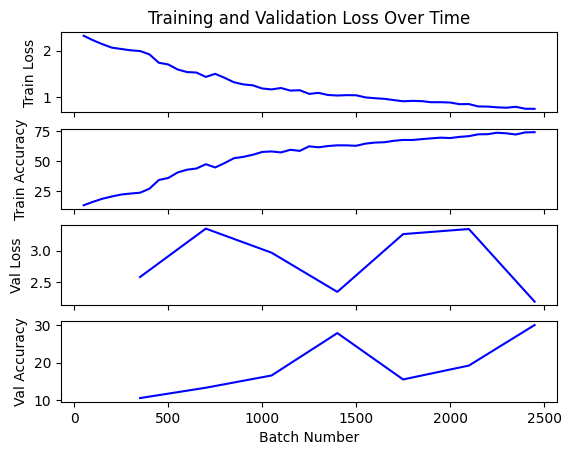

Epoch 8
Batch50, Loss: 0.726, Accuracy: 75.2%
Batch100, Loss: 0.720, Accuracy: 75.5%
Batch150, Loss: 0.704, Accuracy: 75.3%
Batch200, Loss: 0.682, Accuracy: 76.1%
Batch250, Loss: 0.710, Accuracy: 75.4%
Batch300, Loss: 0.703, Accuracy: 75.4%
Batch350, Loss: 0.674, Accuracy: 77.2%
Val Loss: 2.638, Val Accuracy: 33.4%
*****************************************



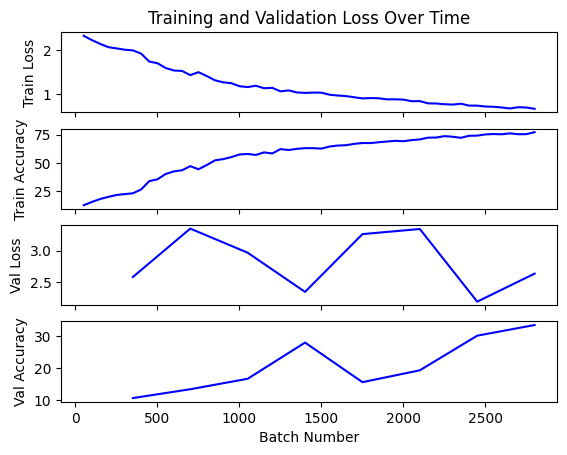

Epoch 9
Batch50, Loss: 0.656, Accuracy: 77.6%
Batch100, Loss: 0.634, Accuracy: 78.1%
Batch150, Loss: 0.664, Accuracy: 77.0%
Batch200, Loss: 0.653, Accuracy: 77.3%
Batch250, Loss: 0.667, Accuracy: 77.2%
Batch300, Loss: 0.671, Accuracy: 76.4%
Batch350, Loss: 0.636, Accuracy: 78.0%
Val Loss: 2.792, Val Accuracy: 28.2%
*****************************************



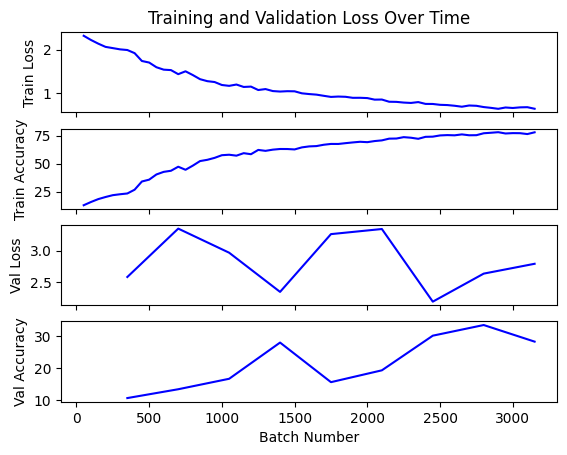

Epoch 10
Batch50, Loss: 0.641, Accuracy: 77.8%
Batch100, Loss: 0.630, Accuracy: 78.1%
Batch150, Loss: 0.601, Accuracy: 79.3%
Batch200, Loss: 0.629, Accuracy: 78.7%
Batch250, Loss: 0.632, Accuracy: 77.8%
Batch300, Loss: 0.596, Accuracy: 79.5%
Batch350, Loss: 0.606, Accuracy: 78.9%
Val Loss: 2.232, Val Accuracy: 33.9%
*****************************************



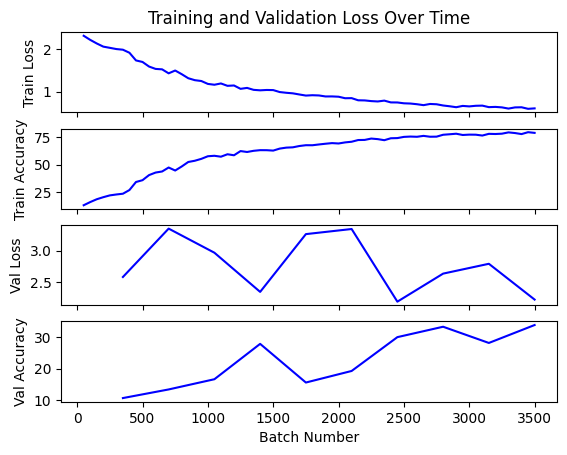

Epoch 11
Batch50, Loss: 0.599, Accuracy: 78.8%
Batch100, Loss: 0.602, Accuracy: 79.1%
Batch150, Loss: 0.583, Accuracy: 79.8%
Batch200, Loss: 0.571, Accuracy: 80.0%
Batch250, Loss: 0.602, Accuracy: 79.6%
Batch300, Loss: 0.595, Accuracy: 79.5%
Batch350, Loss: 0.604, Accuracy: 78.8%
Val Loss: 3.647, Val Accuracy: 18.4%
*****************************************



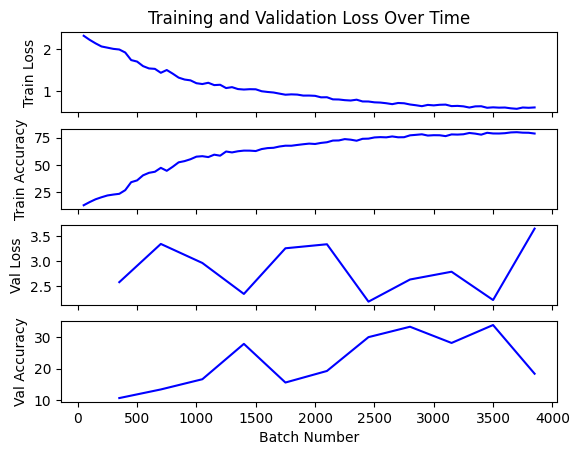

Epoch 12
Batch50, Loss: 0.566, Accuracy: 80.5%
Batch100, Loss: 0.590, Accuracy: 79.9%
Batch150, Loss: 0.569, Accuracy: 80.4%
Batch200, Loss: 0.569, Accuracy: 80.2%
Batch250, Loss: 0.565, Accuracy: 79.8%
Batch300, Loss: 0.574, Accuracy: 80.1%
Batch350, Loss: 0.567, Accuracy: 80.1%
Val Loss: 3.272, Val Accuracy: 25.2%
*****************************************



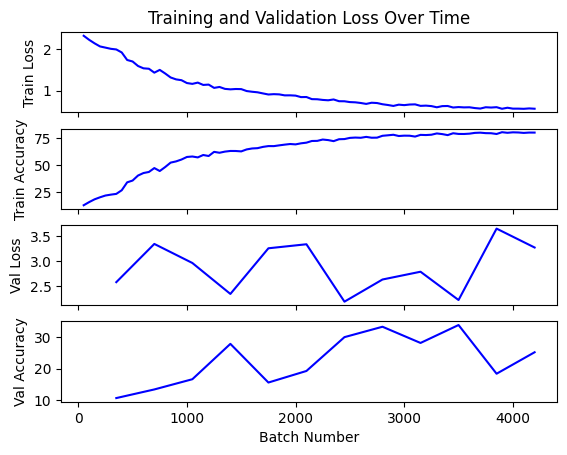

Epoch 13
Batch50, Loss: 0.550, Accuracy: 81.0%
Batch100, Loss: 0.543, Accuracy: 81.3%
Batch150, Loss: 0.542, Accuracy: 81.5%
Batch200, Loss: 0.535, Accuracy: 82.3%
Batch250, Loss: 0.544, Accuracy: 81.5%
Batch300, Loss: 0.555, Accuracy: 81.0%
Batch350, Loss: 0.575, Accuracy: 80.3%
Val Loss: 2.529, Val Accuracy: 31.2%
*****************************************



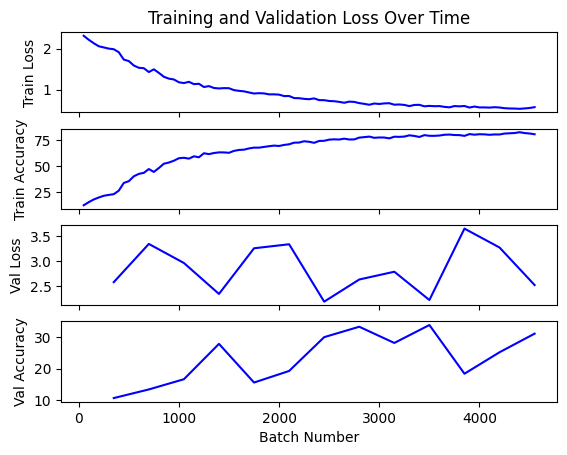

Epoch 14
Batch50, Loss: 0.518, Accuracy: 82.3%
Batch100, Loss: 0.531, Accuracy: 82.0%
Batch150, Loss: 0.540, Accuracy: 81.7%
Batch200, Loss: 0.530, Accuracy: 81.8%
Batch250, Loss: 0.537, Accuracy: 81.6%
Batch300, Loss: 0.522, Accuracy: 81.6%
Batch350, Loss: 0.521, Accuracy: 82.2%
Val Loss: 2.773, Val Accuracy: 29.0%
*****************************************



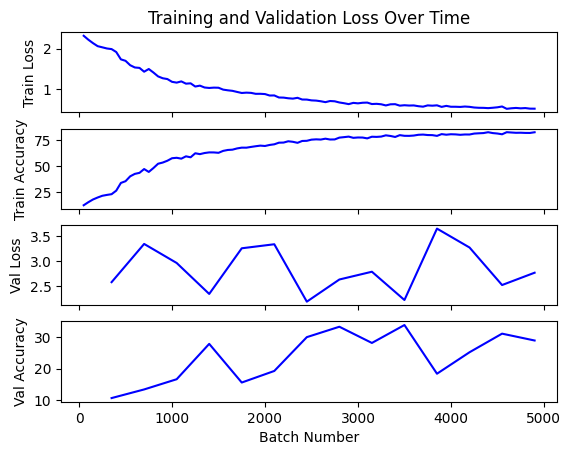

Epoch 15
Batch50, Loss: 0.512, Accuracy: 82.1%
Batch100, Loss: 0.504, Accuracy: 82.4%
Batch150, Loss: 0.499, Accuracy: 82.8%
Batch200, Loss: 0.514, Accuracy: 82.5%
Batch250, Loss: 0.511, Accuracy: 82.3%
Batch300, Loss: 0.520, Accuracy: 82.2%
Batch350, Loss: 0.504, Accuracy: 82.4%
Val Loss: 2.524, Val Accuracy: 32.8%
*****************************************



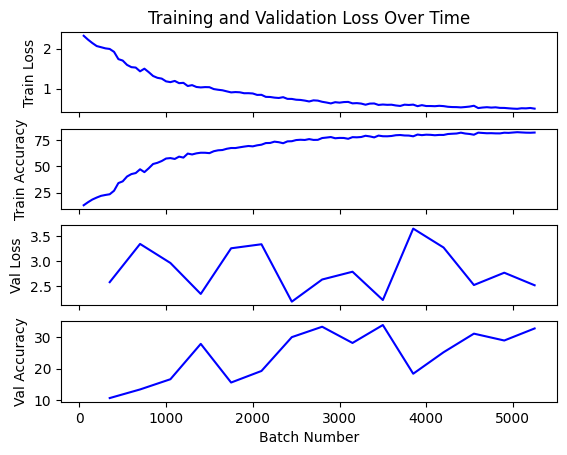

Epoch 16
Batch50, Loss: 0.497, Accuracy: 82.5%
Batch100, Loss: 0.516, Accuracy: 82.5%
Batch150, Loss: 0.492, Accuracy: 82.9%
Batch200, Loss: 0.488, Accuracy: 83.3%
Batch250, Loss: 0.486, Accuracy: 82.9%
Batch300, Loss: 0.501, Accuracy: 82.7%
Batch350, Loss: 0.518, Accuracy: 82.0%
Val Loss: 2.652, Val Accuracy: 35.6%
*****************************************



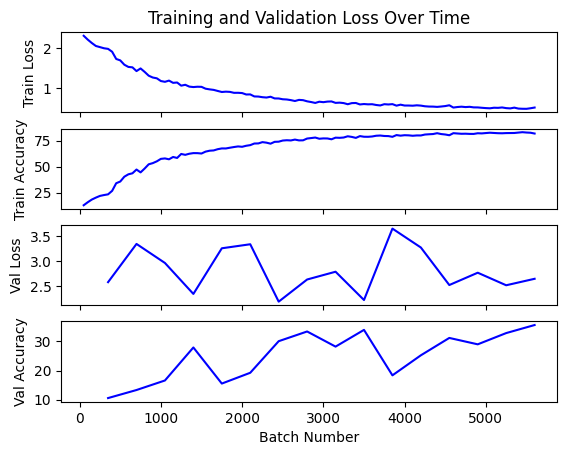

Epoch 17
Batch50, Loss: 0.445, Accuracy: 85.0%
Batch100, Loss: 0.496, Accuracy: 83.2%
Batch150, Loss: 0.515, Accuracy: 82.3%
Batch200, Loss: 0.471, Accuracy: 84.0%
Batch250, Loss: 0.477, Accuracy: 83.2%
Batch300, Loss: 0.458, Accuracy: 84.9%
Batch350, Loss: 0.474, Accuracy: 83.4%
Val Loss: 2.176, Val Accuracy: 39.0%
*****************************************



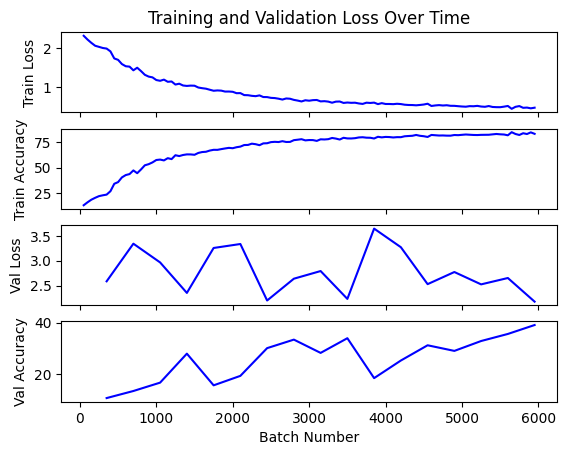

Epoch 18
Batch50, Loss: 0.468, Accuracy: 83.7%
Batch100, Loss: 0.447, Accuracy: 84.6%
Batch150, Loss: 0.483, Accuracy: 82.9%
Batch200, Loss: 0.464, Accuracy: 84.2%
Batch250, Loss: 0.483, Accuracy: 83.1%
Batch300, Loss: 0.474, Accuracy: 83.6%
Batch350, Loss: 0.479, Accuracy: 83.5%
Val Loss: 2.066, Val Accuracy: 41.0%
*****************************************



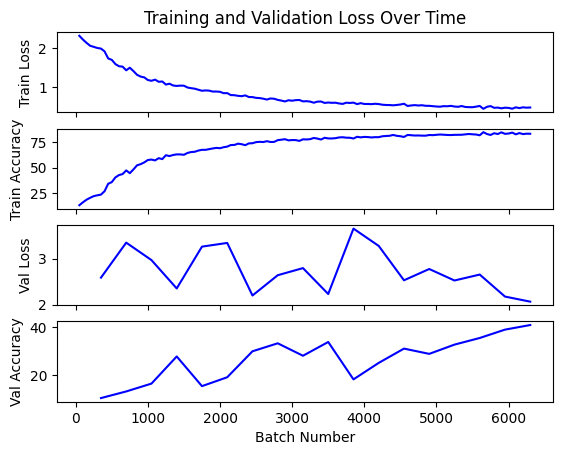

Epoch 19
Batch50, Loss: 0.459, Accuracy: 84.1%
Batch100, Loss: 0.461, Accuracy: 84.5%
Batch150, Loss: 0.450, Accuracy: 84.3%
Batch200, Loss: 0.457, Accuracy: 84.0%
Batch250, Loss: 0.467, Accuracy: 83.4%
Batch300, Loss: 0.481, Accuracy: 83.2%
Batch350, Loss: 0.467, Accuracy: 83.6%
Val Loss: 2.227, Val Accuracy: 31.5%
*****************************************



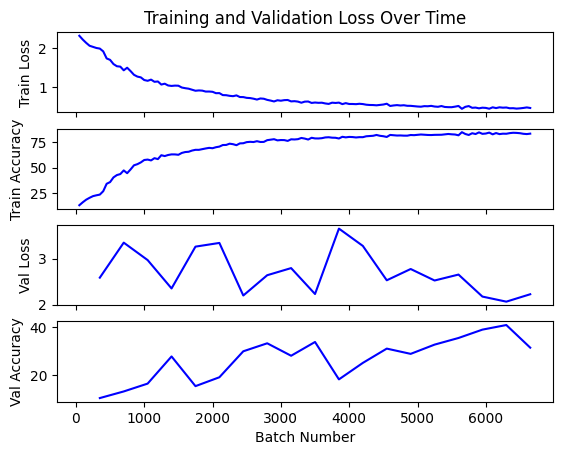

Epoch 20
Batch50, Loss: 0.443, Accuracy: 84.9%
Batch100, Loss: 0.453, Accuracy: 84.2%
Batch150, Loss: 0.464, Accuracy: 84.1%
Batch200, Loss: 0.449, Accuracy: 84.8%
Batch250, Loss: 0.427, Accuracy: 85.5%
Batch300, Loss: 0.437, Accuracy: 85.1%
Batch350, Loss: 0.483, Accuracy: 83.6%
Val Loss: 2.435, Val Accuracy: 28.4%
*****************************************



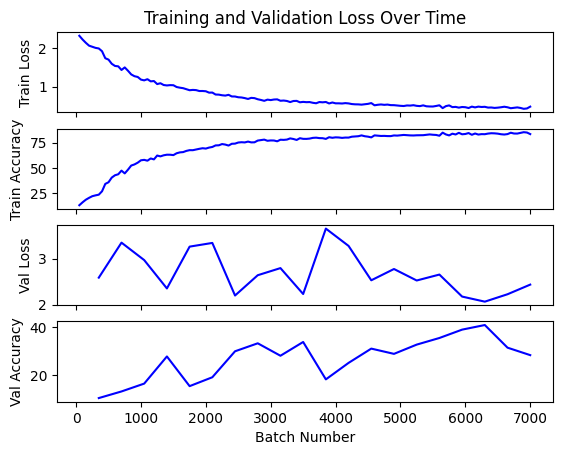

Epoch 21
Batch50, Loss: 0.416, Accuracy: 85.8%
Batch100, Loss: 0.455, Accuracy: 84.2%
Batch150, Loss: 0.441, Accuracy: 84.2%
Batch200, Loss: 0.452, Accuracy: 84.1%
Batch250, Loss: 0.463, Accuracy: 83.7%
Batch300, Loss: 0.460, Accuracy: 84.2%
Batch350, Loss: 0.440, Accuracy: 85.2%
Val Loss: 2.161, Val Accuracy: 33.2%
*****************************************



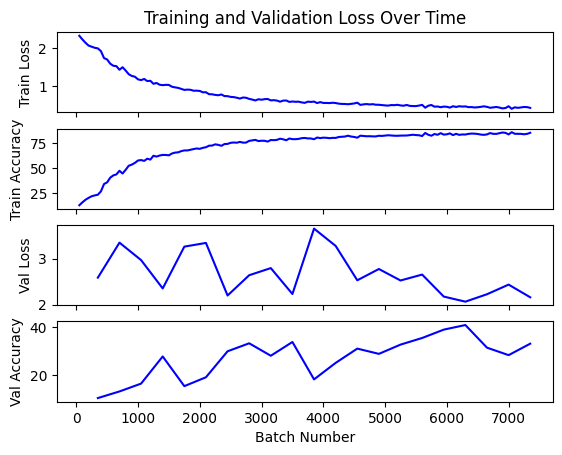

Epoch 22
Batch50, Loss: 0.421, Accuracy: 85.3%
Batch100, Loss: 0.408, Accuracy: 86.0%
Batch150, Loss: 0.438, Accuracy: 84.8%
Batch200, Loss: 0.438, Accuracy: 85.5%
Batch250, Loss: 0.458, Accuracy: 83.6%
Batch300, Loss: 0.436, Accuracy: 85.0%
Batch350, Loss: 0.449, Accuracy: 84.2%
Val Loss: 2.426, Val Accuracy: 36.5%
*****************************************



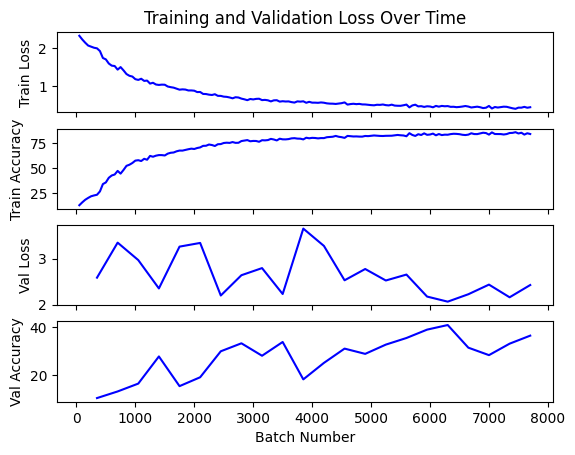

Epoch 23
Batch50, Loss: 0.427, Accuracy: 85.2%
Batch100, Loss: 0.422, Accuracy: 85.8%
Batch150, Loss: 0.413, Accuracy: 85.8%
Batch200, Loss: 0.422, Accuracy: 85.2%
Batch250, Loss: 0.426, Accuracy: 85.0%
Batch300, Loss: 0.444, Accuracy: 84.3%
Batch350, Loss: 0.457, Accuracy: 84.4%
Val Loss: 2.268, Val Accuracy: 35.8%
*****************************************



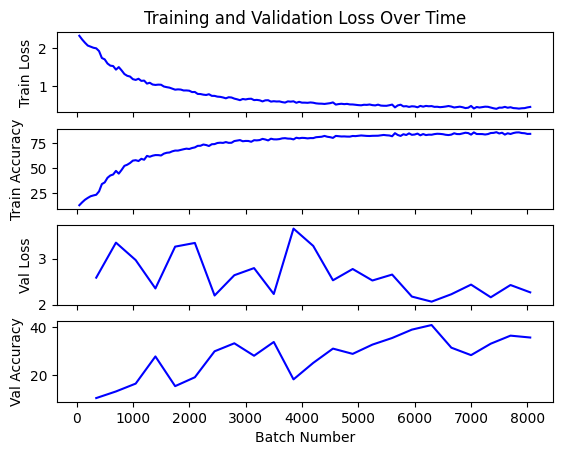

Epoch 24
Batch50, Loss: 0.403, Accuracy: 86.2%
Batch100, Loss: 0.419, Accuracy: 85.2%
Batch150, Loss: 0.406, Accuracy: 85.8%
Batch200, Loss: 0.421, Accuracy: 85.7%
Batch250, Loss: 0.436, Accuracy: 84.9%
Batch300, Loss: 0.406, Accuracy: 85.8%
Batch350, Loss: 0.443, Accuracy: 84.6%
Val Loss: 2.932, Val Accuracy: 31.3%
*****************************************



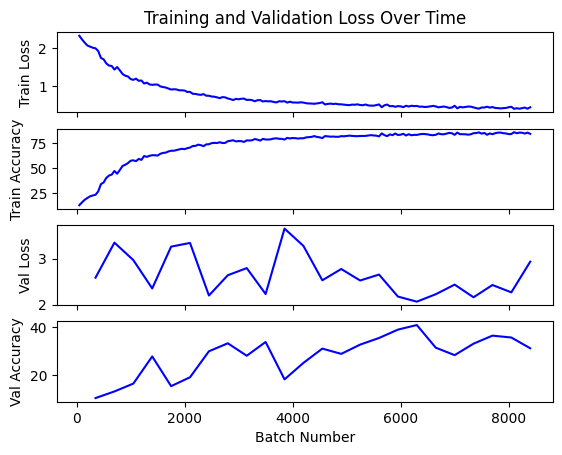

Epoch 25
Batch50, Loss: 0.401, Accuracy: 86.1%
Batch100, Loss: 0.411, Accuracy: 85.8%
Batch150, Loss: 0.412, Accuracy: 85.8%
Batch200, Loss: 0.425, Accuracy: 85.1%
Batch250, Loss: 0.410, Accuracy: 85.5%
Batch300, Loss: 0.398, Accuracy: 85.9%
Batch350, Loss: 0.426, Accuracy: 85.6%
Val Loss: 2.273, Val Accuracy: 40.4%
*****************************************



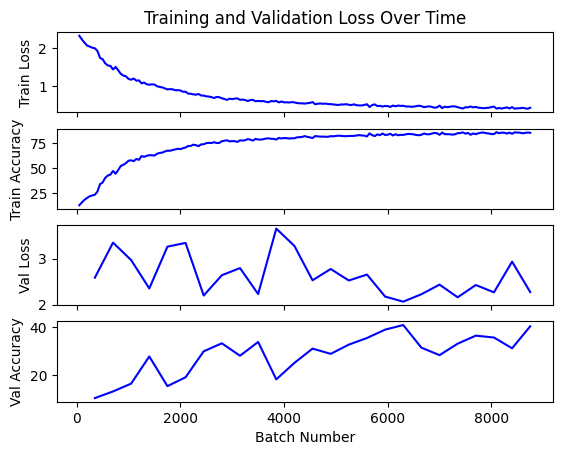

Epoch 26
Batch50, Loss: 0.359, Accuracy: 87.5%
Batch100, Loss: 0.325, Accuracy: 88.8%
Batch150, Loss: 0.318, Accuracy: 89.1%
Batch200, Loss: 0.286, Accuracy: 90.3%
Batch250, Loss: 0.297, Accuracy: 89.9%
Batch300, Loss: 0.296, Accuracy: 89.7%
Batch350, Loss: 0.294, Accuracy: 89.8%
Val Loss: 2.028, Val Accuracy: 42.7%
*****************************************



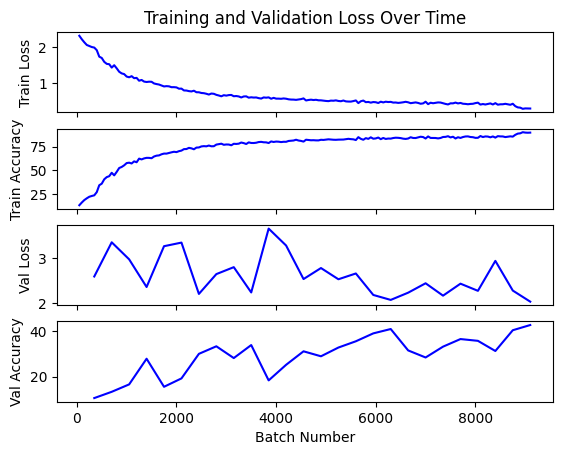

Epoch 27
Batch50, Loss: 0.269, Accuracy: 90.4%
Batch100, Loss: 0.288, Accuracy: 90.4%
Batch150, Loss: 0.265, Accuracy: 91.0%
Batch200, Loss: 0.282, Accuracy: 90.0%
Batch250, Loss: 0.270, Accuracy: 90.6%
Batch300, Loss: 0.263, Accuracy: 90.9%
Batch350, Loss: 0.278, Accuracy: 90.4%
Val Loss: 2.278, Val Accuracy: 39.5%
*****************************************



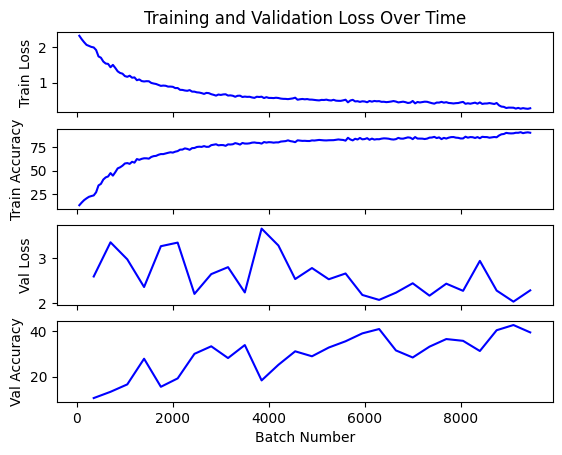

Epoch 28
Batch50, Loss: 0.262, Accuracy: 91.4%
Batch100, Loss: 0.257, Accuracy: 91.1%
Batch150, Loss: 0.260, Accuracy: 90.9%
Batch200, Loss: 0.260, Accuracy: 91.2%
Batch250, Loss: 0.272, Accuracy: 90.6%
Batch300, Loss: 0.252, Accuracy: 91.4%
Batch350, Loss: 0.262, Accuracy: 91.1%
Val Loss: 2.109, Val Accuracy: 43.2%
*****************************************



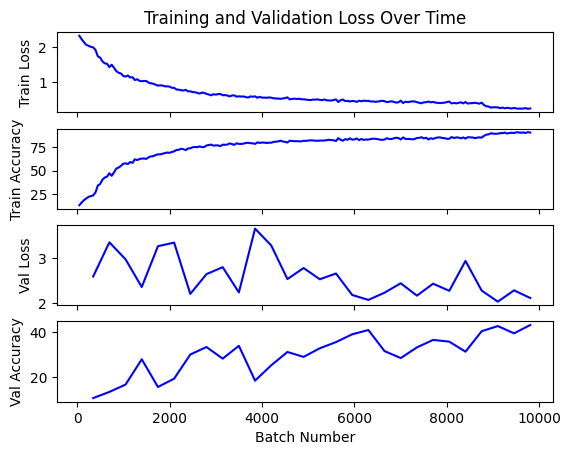

Epoch 29
Batch50, Loss: 0.246, Accuracy: 91.8%
Batch100, Loss: 0.241, Accuracy: 91.9%
Batch150, Loss: 0.263, Accuracy: 90.9%
Batch200, Loss: 0.234, Accuracy: 92.1%
Batch250, Loss: 0.255, Accuracy: 91.0%
Batch300, Loss: 0.263, Accuracy: 90.9%
Batch350, Loss: 0.255, Accuracy: 90.9%
Val Loss: 2.090, Val Accuracy: 44.6%
*****************************************



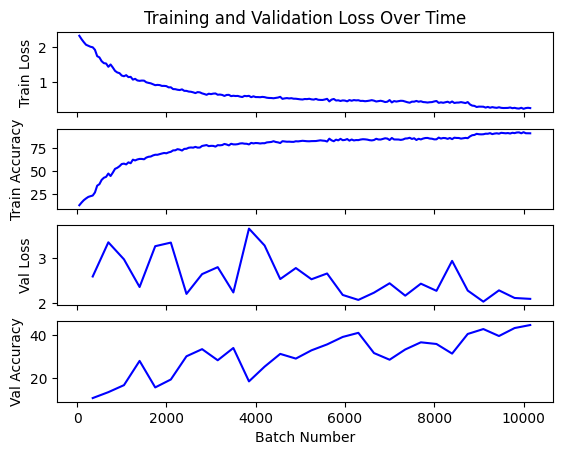

Epoch 30
Batch50, Loss: 0.233, Accuracy: 92.3%
Batch100, Loss: 0.235, Accuracy: 91.7%
Batch150, Loss: 0.247, Accuracy: 91.6%
Batch200, Loss: 0.231, Accuracy: 92.1%
Batch250, Loss: 0.243, Accuracy: 91.6%
Batch300, Loss: 0.255, Accuracy: 91.0%
Batch350, Loss: 0.250, Accuracy: 91.6%
Val Loss: 2.372, Val Accuracy: 43.2%
*****************************************



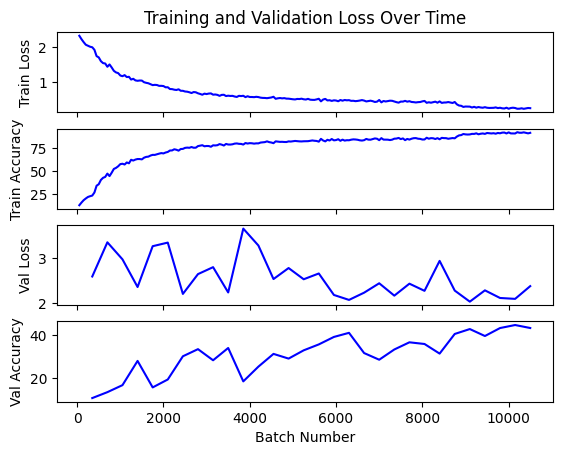

Epoch 31
Batch50, Loss: 0.233, Accuracy: 92.0%
Batch100, Loss: 0.239, Accuracy: 91.6%
Batch150, Loss: 0.242, Accuracy: 91.8%
Batch200, Loss: 0.231, Accuracy: 91.8%
Batch250, Loss: 0.241, Accuracy: 91.7%
Batch300, Loss: 0.245, Accuracy: 91.5%
Batch350, Loss: 0.248, Accuracy: 91.8%
Val Loss: 2.140, Val Accuracy: 45.8%
*****************************************



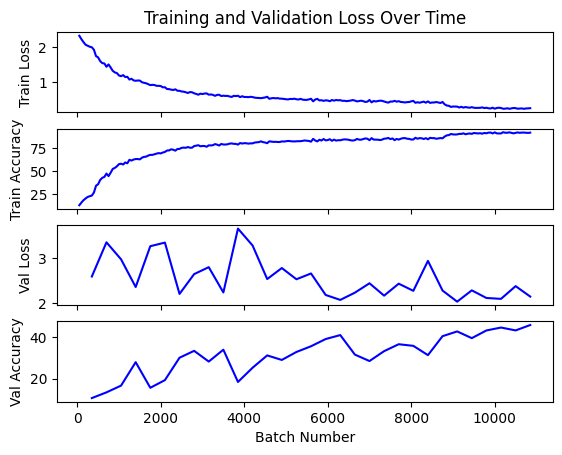

Epoch 32
Batch50, Loss: 0.219, Accuracy: 92.4%
Batch100, Loss: 0.238, Accuracy: 91.9%
Batch150, Loss: 0.250, Accuracy: 91.1%
Batch200, Loss: 0.238, Accuracy: 92.0%
Batch250, Loss: 0.232, Accuracy: 92.0%
Batch300, Loss: 0.229, Accuracy: 92.3%
Batch350, Loss: 0.225, Accuracy: 92.2%
Val Loss: 2.187, Val Accuracy: 45.9%
*****************************************



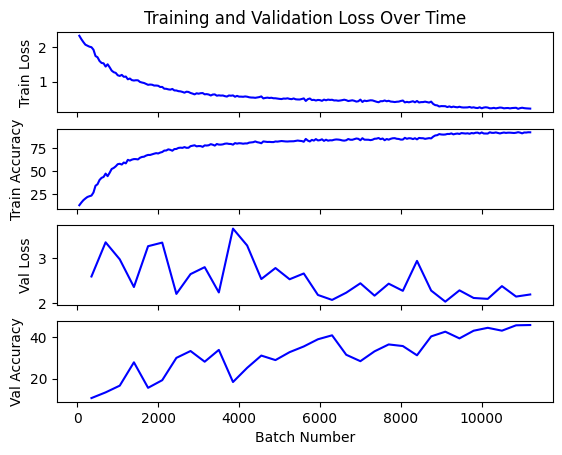

Epoch 33
Batch50, Loss: 0.222, Accuracy: 92.1%
Batch100, Loss: 0.234, Accuracy: 91.8%
Batch150, Loss: 0.223, Accuracy: 92.5%
Batch200, Loss: 0.214, Accuracy: 92.6%
Batch250, Loss: 0.235, Accuracy: 91.6%
Batch300, Loss: 0.235, Accuracy: 91.8%
Batch350, Loss: 0.234, Accuracy: 92.0%
Val Loss: 2.123, Val Accuracy: 47.0%
*****************************************



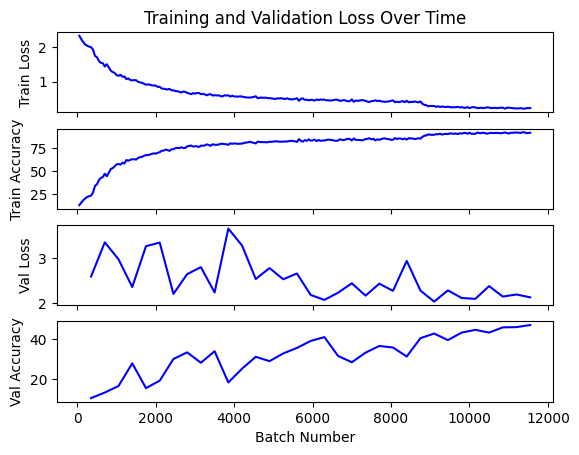

Epoch 34
Batch50, Loss: 0.214, Accuracy: 92.7%
Batch100, Loss: 0.220, Accuracy: 92.7%
Batch150, Loss: 0.220, Accuracy: 92.6%
Batch200, Loss: 0.221, Accuracy: 92.2%
Batch250, Loss: 0.217, Accuracy: 92.7%
Batch300, Loss: 0.209, Accuracy: 92.5%
Batch350, Loss: 0.241, Accuracy: 91.6%
Val Loss: 2.306, Val Accuracy: 43.4%
*****************************************



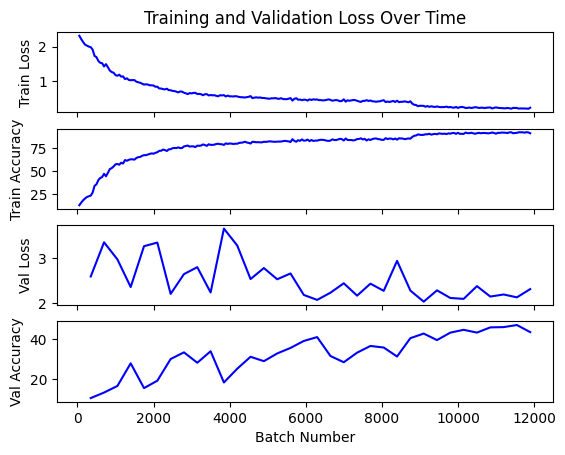

Epoch 35
Batch50, Loss: 0.213, Accuracy: 92.6%
Batch100, Loss: 0.212, Accuracy: 92.5%
Batch150, Loss: 0.200, Accuracy: 92.9%
Batch200, Loss: 0.214, Accuracy: 92.7%
Batch250, Loss: 0.234, Accuracy: 92.1%
Batch300, Loss: 0.232, Accuracy: 92.2%
Batch350, Loss: 0.222, Accuracy: 92.4%
Val Loss: 2.671, Val Accuracy: 39.0%
*****************************************



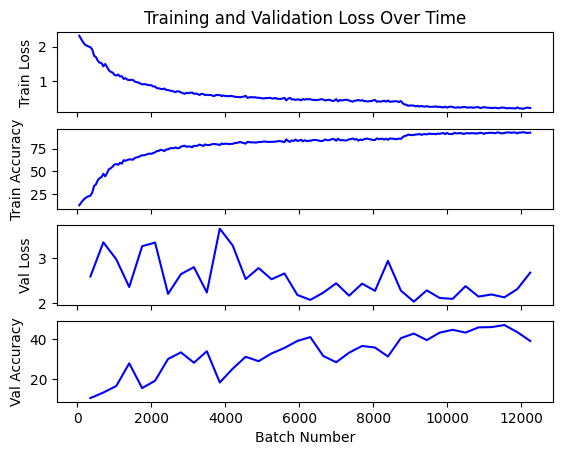

Epoch 36
Batch50, Loss: 0.211, Accuracy: 92.5%
Batch100, Loss: 0.221, Accuracy: 92.0%
Batch150, Loss: 0.205, Accuracy: 92.9%
Batch200, Loss: 0.202, Accuracy: 93.3%
Batch250, Loss: 0.197, Accuracy: 93.2%
Batch300, Loss: 0.195, Accuracy: 92.9%
Batch350, Loss: 0.202, Accuracy: 92.9%
Val Loss: 2.549, Val Accuracy: 40.9%
*****************************************



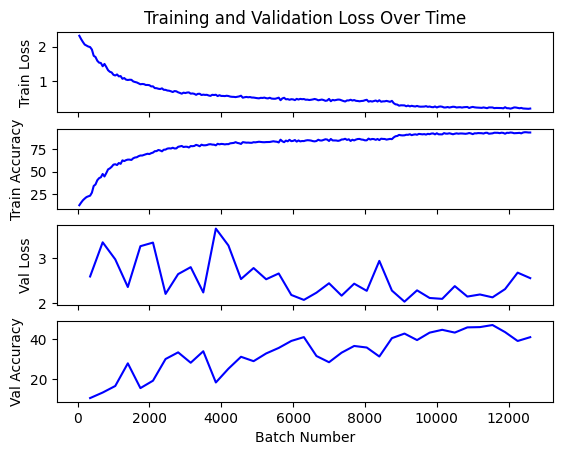

Epoch 37
Batch50, Loss: 0.203, Accuracy: 93.0%
Batch100, Loss: 0.202, Accuracy: 93.0%
Batch150, Loss: 0.208, Accuracy: 92.7%
Batch200, Loss: 0.191, Accuracy: 93.5%
Batch250, Loss: 0.217, Accuracy: 92.6%
Batch300, Loss: 0.188, Accuracy: 93.6%
Batch350, Loss: 0.198, Accuracy: 93.1%
Val Loss: 2.507, Val Accuracy: 42.0%
*****************************************



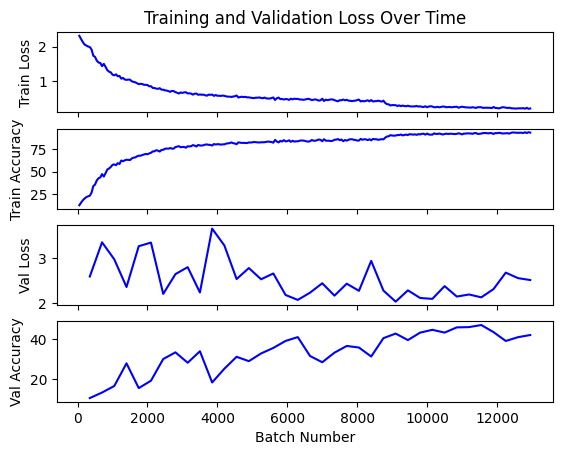

Epoch 38
Batch50, Loss: 0.189, Accuracy: 93.4%
Batch100, Loss: 0.203, Accuracy: 93.1%
Batch150, Loss: 0.208, Accuracy: 92.9%
Batch200, Loss: 0.200, Accuracy: 92.8%
Batch250, Loss: 0.196, Accuracy: 93.3%
Batch300, Loss: 0.195, Accuracy: 93.4%
Batch350, Loss: 0.206, Accuracy: 92.6%
Val Loss: 2.473, Val Accuracy: 42.5%
*****************************************



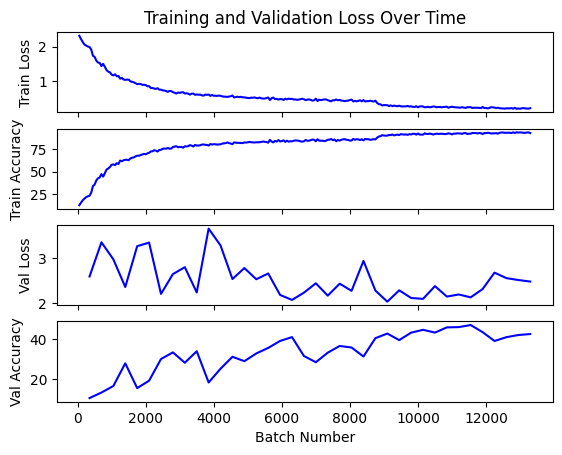

Epoch 39
Batch50, Loss: 0.187, Accuracy: 93.7%
Batch100, Loss: 0.210, Accuracy: 92.9%
Batch150, Loss: 0.208, Accuracy: 92.8%
Batch200, Loss: 0.200, Accuracy: 92.8%
Batch250, Loss: 0.210, Accuracy: 92.5%
Batch300, Loss: 0.205, Accuracy: 92.8%
Batch350, Loss: 0.197, Accuracy: 93.3%
Val Loss: 2.325, Val Accuracy: 44.3%
*****************************************



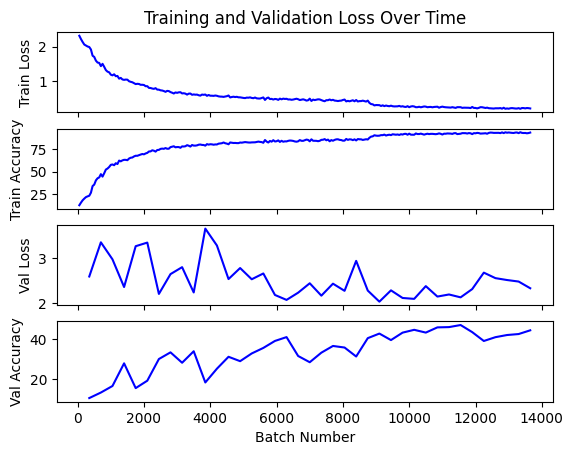

Epoch 40
Batch50, Loss: 0.196, Accuracy: 93.3%
Batch100, Loss: 0.224, Accuracy: 92.1%
Batch150, Loss: 0.194, Accuracy: 93.5%
Batch200, Loss: 0.198, Accuracy: 93.1%
Batch250, Loss: 0.208, Accuracy: 92.8%
Batch300, Loss: 0.198, Accuracy: 93.1%
Batch350, Loss: 0.195, Accuracy: 93.3%
Val Loss: 2.397, Val Accuracy: 43.6%
*****************************************



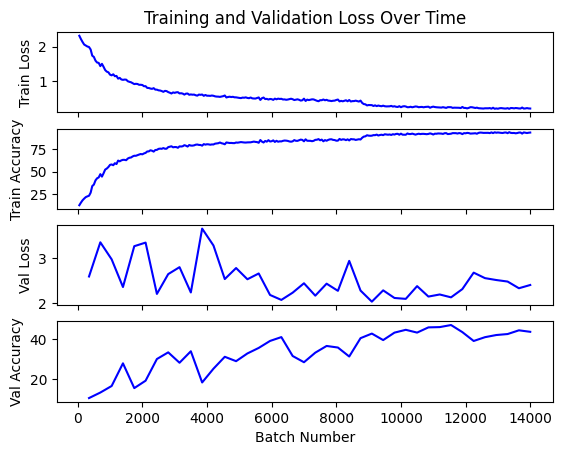

Epoch 41
Batch50, Loss: 0.205, Accuracy: 92.9%
Batch100, Loss: 0.184, Accuracy: 93.6%
Batch150, Loss: 0.198, Accuracy: 92.9%
Batch200, Loss: 0.198, Accuracy: 93.2%
Batch250, Loss: 0.193, Accuracy: 93.5%
Batch300, Loss: 0.209, Accuracy: 92.7%
Batch350, Loss: 0.202, Accuracy: 93.1%
Val Loss: 2.435, Val Accuracy: 43.2%
*****************************************



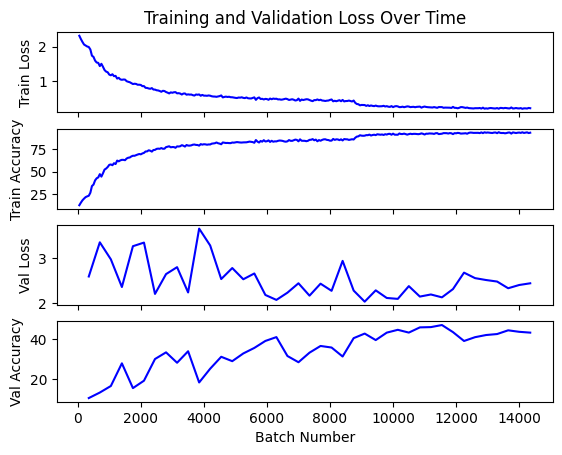

Epoch 42
Batch50, Loss: 0.197, Accuracy: 93.5%
Batch100, Loss: 0.182, Accuracy: 93.7%
Batch150, Loss: 0.199, Accuracy: 93.4%
Batch200, Loss: 0.202, Accuracy: 92.9%
Batch250, Loss: 0.203, Accuracy: 93.0%
Batch300, Loss: 0.194, Accuracy: 93.5%
Batch350, Loss: 0.193, Accuracy: 93.2%
Val Loss: 2.443, Val Accuracy: 43.0%
*****************************************



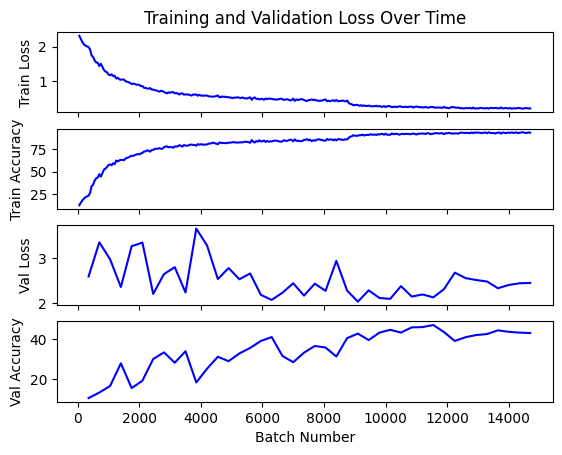

Epoch 43
Batch50, Loss: 0.198, Accuracy: 93.0%
Batch100, Loss: 0.201, Accuracy: 93.1%
Batch150, Loss: 0.214, Accuracy: 92.8%
Batch200, Loss: 0.193, Accuracy: 93.3%
Batch250, Loss: 0.189, Accuracy: 93.4%
Batch300, Loss: 0.200, Accuracy: 93.1%
Batch350, Loss: 0.185, Accuracy: 93.4%
Val Loss: 2.346, Val Accuracy: 44.4%
*****************************************



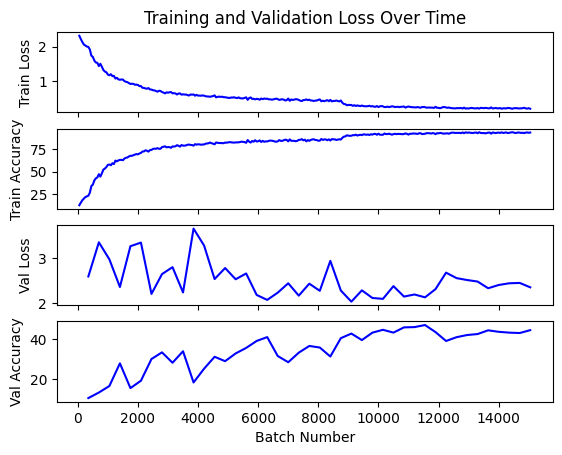

Epoch 44
Batch50, Loss: 0.197, Accuracy: 93.2%
Batch100, Loss: 0.192, Accuracy: 93.9%
Batch150, Loss: 0.203, Accuracy: 93.2%
Batch200, Loss: 0.196, Accuracy: 93.1%
Batch250, Loss: 0.190, Accuracy: 93.2%
Batch300, Loss: 0.192, Accuracy: 93.7%
Batch350, Loss: 0.195, Accuracy: 93.1%
Val Loss: 2.527, Val Accuracy: 43.1%
*****************************************



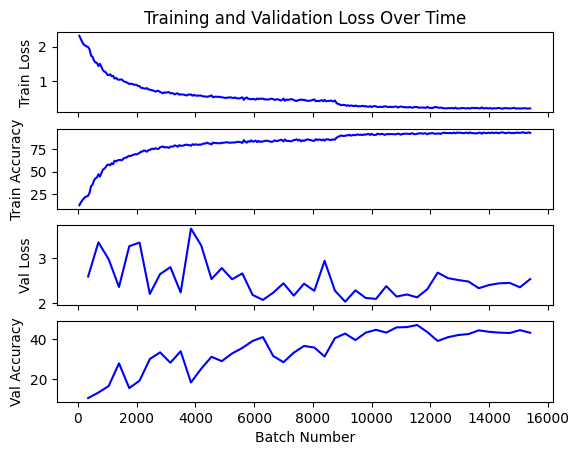

Epoch 45
Batch50, Loss: 0.200, Accuracy: 93.3%
Batch100, Loss: 0.198, Accuracy: 92.9%
Batch150, Loss: 0.195, Accuracy: 93.0%
Batch200, Loss: 0.193, Accuracy: 93.4%
Batch250, Loss: 0.195, Accuracy: 93.1%
Batch300, Loss: 0.191, Accuracy: 93.5%
Batch350, Loss: 0.202, Accuracy: 92.9%
Val Loss: 2.459, Val Accuracy: 43.4%
*****************************************



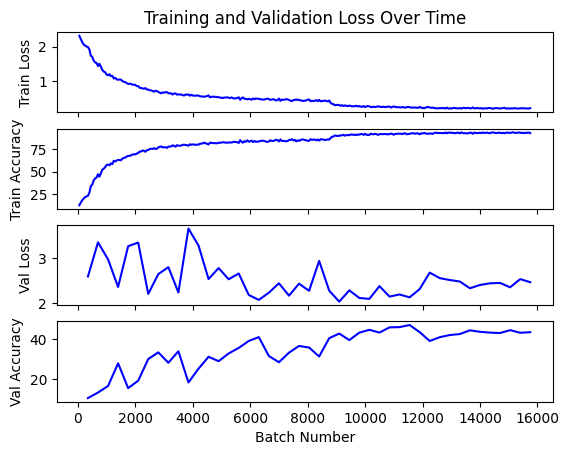

In [8]:
#Sets up CNN, optimizer, and loss function
resnet = Resnet()
resnet.to(device)
resnet.apply(he_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# Warmup: LR increases linearly from 1e-3 → 0.1 over 5 epochs
warmup_scheduler = LinearLR(optimizer, start_factor=0.01, total_iters=5)

# Then switch to MultiStepLR
main_scheduler = MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)

# Combine the two
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[5])
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1) #milestones [91, 136] as per paper
#optimizer = optim.Adam(resnet.parameters(), lr=0.0001)


batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

#Trains the CNN
num_epochs = 45 #182 in the paper
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(resnet, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    losses_toadd, accuracy_toadd = validate_epoch(resnet, criterion)
    resnet.train()
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)
    scheduler.step()

    #Plot
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

# Save the loss data so that we can process/graph it later
folder_path = "Resnet1"
os.makedirs(folder_path, exist_ok=True)

to_save = {
    "batches_training": batches_training,
    "losses_training": losses_training,
    "accuracies_training": accuracies_training,
    "batches_validation": batches_validation,
    "losses_validation": losses_validation,
    "accuracies_validation": accuracies_validation
}




In [15]:
for name, array in to_save.items():
    file_path = os.path.join(folder_path, f"{name}.npy")
    np.save(file_path, array)
    print(f"Saved {name} to {file_path}")

Saved batches_training to Resnet1\batches_training.npy
Saved losses_training to Resnet1\losses_training.npy
Saved accuracies_training to Resnet1\accuracies_training.npy
Saved batches_validation to Resnet1\batches_validation.npy
Saved losses_validation to Resnet1\losses_validation.npy
Saved accuracies_validation to Resnet1\accuracies_validation.npy


In [9]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
resnet.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

Accuracy 45.45


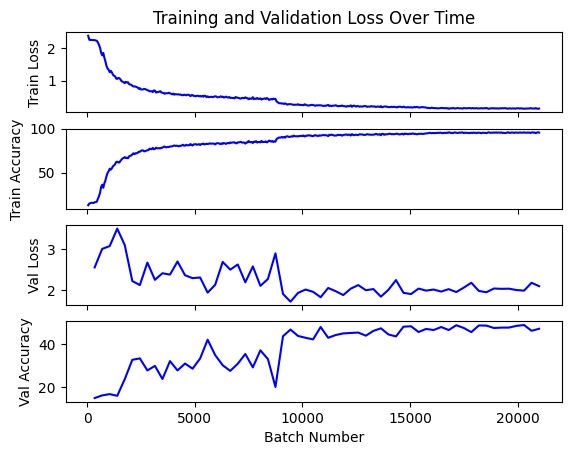

In [48]:
to_load = [
    "batches_training",
    "losses_training",
    "accuracies_training",
    "batches_validation",
    "losses_validation",
    "accuracies_validation"
]
batches_training = np.load(f'Resnet1/{to_load[0]}.npy')
losses_training = np.load(f'Resnet1/{to_load[1]}.npy')
accuracies_training = np.load(f'Resnet1/{to_load[2]}.npy')
batches_validation = np.load(f'Resnet1/{to_load[3]}.npy')
losses_validation = np.load(f'Resnet1/{to_load[4]}.npy')
accuracies_validation = np.load(f'Resnet1/{to_load[5]}.npy')

fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

In [ ]:
torch.save(resnet, 'DeepResNetParams.pth')

In [ ]:
#Loads previously trained models
with torch.serialization.safe_globals([Resnet]):
    resnet = torch.load('DeepResNetParams.pth', weights_only=False)
resnet.to(device)

In [3]:
test_iter = iter(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: truck


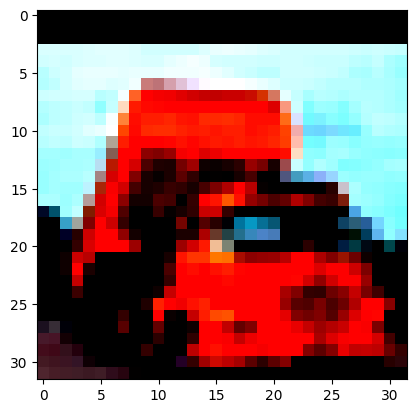

In [8]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
#resnet.train(False)
#guess_labels = resnet(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
#guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]]}")
#print(f"Guess label: {class_names[guess_label]}")
plt.imshow(np_img.transpose((1, 2, 0)))